In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sklearn as sk
import sklearn.gaussian_process as gp
from datetime import timedelta as dt

In [167]:
df = pd.read_csv('sotonmet.txt')

Defining variables by indexing columns from DataFrame

In [168]:
t = df['Reading Date and Time (ISO)'] #time
y = df['Tide height (m)']   #Tide height reading
y_true = df['True tide height (m)'] #Ground truth tide heights

Plot of Tide Height (m) against DateTime (ISO)

In [169]:
# Convert t's elements from string to DateTime objects
t=t.apply(datetime.datetime.fromisoformat)

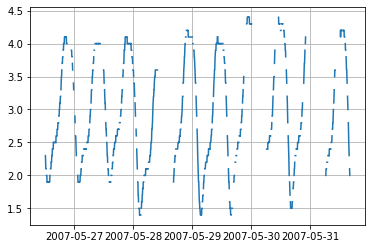

In [170]:
plt.plot(t,y)
plt.grid()

Tide Height displays periodicity as can be seen in plot above.

Start with Expo

In [171]:
df['Reading Date and Time (ISO)']=df['Reading Date and Time (ISO)'].apply(datetime.datetime.fromisoformat)

In [172]:
df['Time'] = np.nan
df['Time'] = (df['Reading Date and Time (ISO)']-df['Reading Date and Time (ISO)'].iloc[0])
df['Time']=df['Time'].dt.total_seconds()

In [173]:
df_training=df.drop(df[df['Tide height (m)'].isnull()].index)
df_missing = df[df['Tide height (m)'].isnull()]

In [174]:
X = df_training[['Tide height (m)','Time']].to_numpy()
X_missing = df_missing['Time'].to_numpy()
X_GT=df_missing['True tide height (m)'].to_numpy()

In [175]:
x_training=X[:,0].reshape(-1,1)
t_training = X[:,1].reshape(-1,1)
X_GT = X_GT.reshape(-1,1)

In [176]:
t2=X_missing.reshape(-1,1)


In [161]:
kernel2=gp.kernels.RBF(length_scale=0.01,length_scale_bounds=(1e-7,1e5)) + gp.kernels.WhiteKernel()

In [162]:
gpr=gp.GaussianProcessRegressor(normalize_y=False,kernel=kernel2,n_restarts_optimizer=10)
gpr.fit(t_training,x_training)

GaussianProcessRegressor(kernel=RBF(length_scale=0.001) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [163]:
answer=gpr.predict(t2)

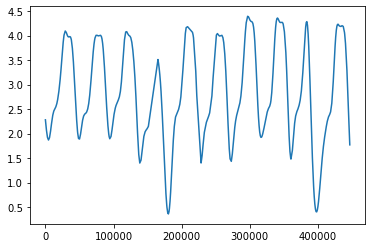

In [164]:
plt.plot(t2,answer)


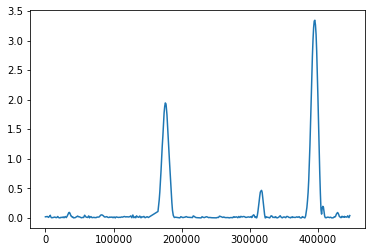

In [165]:
plt.plot(t2,abs(answer-X_GT))

In [130]:
d1={}
for A,B in zip(np.reshape(t2,-1),np.reshape(answer,-1)):
    d1[A]=B

d2={}
for A,B in zip(np.reshape(t2,-1),np.reshape(X_GT,-1)):
    d2[A]=B

In [132]:
df_index = df.set_index('Time')
df_predicted=df_index['Tide height (m)'].fillna(d1)
df_actual=df_index['Tide height (m)'].fillna(d2)

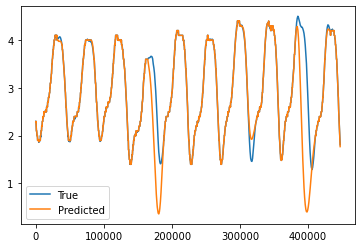

In [160]:
plt.plot(df_actual.index,df_actual,label='True')
plt.plot(df_predicted.index,df_predicted,label='Predicted')
plt.legend()

In [190]:
kernel3=gp.kernels.ExpSineSquared() + gp.kernels.WhiteKernel()

In [191]:
gpr=gp.GaussianProcessRegressor(normalize_y=False,kernel=kernel3,n_restarts_optimizer=10)
gpr.fit(t_training,x_training)

/Users/terencetan/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [192]:
answer=gpr.predict(t2)

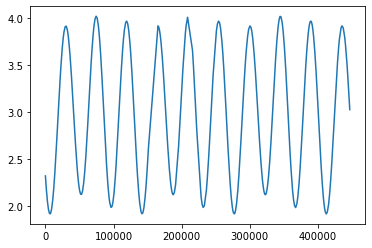

In [193]:
plt.plot(t2,answer)


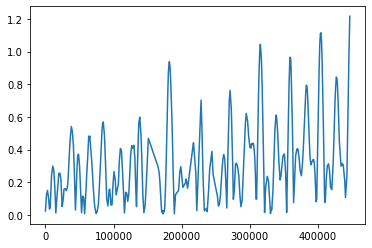

In [194]:
plt.plot(t2,abs(answer-X_GT))

In [195]:
d1={}
for A,B in zip(np.reshape(t2,-1),np.reshape(answer,-1)):
    d1[A]=B

d2={}
for A,B in zip(np.reshape(t2,-1),np.reshape(X_GT,-1)):
    d2[A]=B

In [196]:
df_index = df.set_index('Time')
df_predicted=df_index['Tide height (m)'].fillna(d1)
df_actual=df_index['Tide height (m)'].fillna(d2)

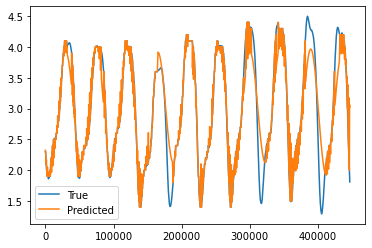

In [197]:
plt.plot(df_actual.index,df_actual,label='True')
plt.plot(df_predicted.index,df_predicted,label='Predicted')
plt.legend()